### Monte Carlo Release-Recapture Temperatures

In [1]:
using BeamPropagation,
    Distributions, 
    UnitsToValue,
    StatsBase, 
    StaticArrays, 
    Plots,
    StructArrays,
    MutableNamedTuples,
    PhysicalConstants.CODATA2018,
    LinearAlgebra

In [2]:
# Define physical constants
const kB = BoltzmannConstant.val
const T = @with_unit 300 "μK"

# Define molecule parameters for CaOH
const m = @with_unit 57 "u"
const v_recoil = @with_unit 1.1 "cm/s"
;

In [241]:
# Define tweezer beam properties
const T_depth = @with_unit 4200 "μK"
const U_max = kB * T_depth
const λ = 1064e-9
const w0x = 9.4e-6
const w0y = 9.4e-6

# Create an instance of a gaussian trap for the tweezer
trap = AsymmetricGaussianTrap(λ=λ, w0x=w0x, w0y=w0y, U_max=U_max, m=m)
;

In [243]:
total_time = @with_unit 8 "ms"               
release_start_time = @with_unit 200 "μs"        
release_end_time = @with_unit 400 "μs"         
;

In [297]:
n = 5000
save_every = 100
delete_every = 50
dt_min = 1e-10
dt_max = 1e-4
abstol = 1e-5
dt = 1e-8
max_steps = Int64(ceil(total_time / dt))
alg = "euler"
use_adaptive = false
dt0 = 1e-5
times = (0:dt:max_steps * dt)[1:save_every:end-1]
;

In [298]:
using DifferentialEquations

In [299]:
function update(particles, p, s, dt, time, idx)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        r = particles.r[i]
        s.detectable[idx] = is_detectable(r, p.trap)
    end
    return nothing
end

gravity(r) = SVector(0.0, -9.81, 0.0)

function f(idx, r, v, p, time)
    if p.release_start_time < time < p.release_end_time
        U_depth = p.trap.U_max * 0.0
    elseif time < p.release_start_time
        U_depth = p.trap.U_max
    elseif time > p.release_end_time
        U_depth = p.trap.U_max * (0.75 / 3.5)
    end
    return F(r, p.trap) * U_depth / m + gravity(r)
end

function save(particles, p, s)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        push!(s.trajectories[idx], particles.r[i])
    end
    return nothing
end
;

In [300]:
discard(r, v) = false
is_detectable(r, trap) = (abs(r[1]) < 3trap.w0x) && (abs(r[2]) < 3trap.w0y) && (abs(r[3]) < 3max(trap.zRx, trap.zRy))

gravity(u) = SVector(0.0, -9.81, 0.0)

function update!(du, u, p, t)
    if p.release_start_time < t < p.release_end_time
        U_depth = p.trap.U_max * 0.0
    elseif t < p.release_start_time
        U_depth = p.trap.U_max
    elseif t > p.release_end_time
        U_depth = p.trap.U_max * (0.75 / 3.5)
    end
    a = F(u, p.trap) * U_depth / m + gravity(u)
    for i ∈ 1:3
        du[i] = u[i+3] # change in position
        du[i+3] = a[i] # change in velocity
    end
    return nothing
end
;

In [301]:
r, v, a = make_distributions(T, trap)
p = @params (trap, release_start_time, release_end_time, r, v, a)
;

In [302]:
# using BenchmarkTools
# u = deepcopy(u0)
# du = deepcopy(u0)
# @btime update!(du, u, p, 0.0)

In [303]:
u0 = [1e-6, 1e-6, 1e-6, 0, 0, 0]
tspan = (0.0, 8e-3)
prob = ODEProblem(update!, u0, tspan, p, alg=DP5(), reltol=1e-7, saveat=0.01e-3)
@time sol = solve(prob)
;

  0.171424 seconds (166.42 k allocations: 11.456 MiB, 99.85% compilation time: 100% of which was recompilation)


In [304]:
function prob_func(prob, i, repeat)
    r = prob.p.r
    v = prob.p.v
    prob.u0[1] = rand(r[1])
    prob.u0[2] = rand(r[2])
    prob.u0[3] = rand(r[3])
    prob.u0[4] = rand(v[1])
    prob.u0[5] = rand(v[2])
    prob.u0[6] = rand(v[3])
    return prob
end
;

In [305]:
ensemble_prob = EnsembleProblem(prob, prob_func=prob_func)
@time ensemble_sol = solve(ensemble_prob, EnsembleThreads(); trajectories=n)
;

  0.368789 seconds (4.59 M allocations: 678.072 MiB, 220.44% compilation time: 18% of which was recompilation)


In [306]:
times = ensemble_sol[1].t
survived = zeros(length(times))

@time for i ∈ eachindex(times)
    for j ∈ eachindex(ensemble_sol)
        survived[i] += is_detectable(ensemble_sol[j].u[i], p.trap)
    end
end

  6.875284 seconds (35.23 M allocations: 6.433 GiB, 20.19% gc time, 0.15% compilation time)


In [307]:
ensemble_sol[1].t[2]

1.0e-5

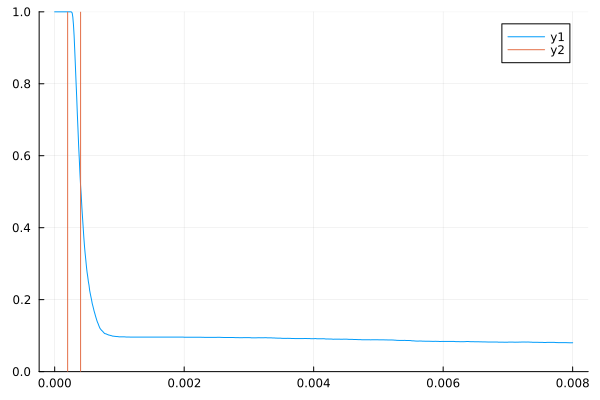

In [308]:
plot(times, survived ./ n, ylim=(0,1))
vline!([release_start_time, release_end_time])

## Scan in-trap temperature to fit to data

In [309]:
root_path = "X:\\Shared drives\\CaOH Data 2024_2\\Data Folder\\CameraImages\\20240415"

start_file = "1718_40"
end_file = "1735_00"
;

In [310]:
using MAT

In [311]:
files = readdir(root_path)
files = files[start_file .< files .< end_file]
;

In [312]:
all_data = []
for file ∈ files
    file_path = root_path * "\\" * file * "\\AllImages.mat"
    data = matread(file_path)
    push!(all_data, data)
end

# get the parameters
all_parameters = [data["parameter_values"][1] for data ∈ all_data]
unique_params = sort(unique(all_parameters))
param_to_idx = Dict(unique_params[i] => i for i ∈ eachindex(unique_params))
n_params = length(unique_params)
;

In [313]:
x_center = 10
y_center = 10
roi = 5

x_roi = (x_center - roi):(x_center + roi)
y_roi = (y_center - roi):(y_center + roi)

img1_summed = zeros(n_params, 2roi+1, 2roi+1)
img2_summed = zeros(n_params, 2roi+1, 2roi+1)
img1_bg_summed = zeros(n_params, 2roi+1, 2roi+1)
img2_bg_summed = zeros(n_params, 2roi+1, 2roi+1)

n_datapts = zeros(n_params)

for data ∈ all_data
    image_data = data["AllImages"]
    parameter = data["parameter_values"][1]
    parameter_idx = param_to_idx[parameter]
    
    img1 = sum(image_data[x_roi,y_roi,:,1], dims=3)
    img2 = sum(image_data[x_roi,y_roi,:,2], dims=3)
    img1_bg = sum(image_data[x_roi,y_roi,:,3], dims=3)
    img2_bg = sum(image_data[x_roi,y_roi,:,4], dims=3)

    img1_summed[parameter_idx,:,:] .+= img1
    img2_summed[parameter_idx,:,:] .+= img2
    img1_bg_summed[parameter_idx,:,:] .+= img1_bg
    img2_bg_summed[parameter_idx,:,:] .+= img2_bg
    n_datapts[parameter_idx] += size(image_data, 3)
end

img1_mean = img1_summed ./ n_datapts
img2_mean = img2_summed ./ n_datapts
img1_bg_mean = img1_bg_summed ./ n_datapts
img2_bg_mean = img2_bg_summed ./ n_datapts


img1_sums = sum(img1_mean, dims=(2,3))[:,1,1]
img2_sums = sum(img2_mean, dims=(2,3))[:,1,1]
img1_bg_sums = sum(img1_bg_mean, dims=(2,3))[:,1,1]
img2_bg_sums = sum(img2_bg_mean, dims=(2,3))[:,1,1]
;

In [314]:
function survival_func(img1_sum, img2_sum, img1_bg_sum, img2_bg_sum)
    return (img2_sum - img2_bg_sum) / (img1_sum - img1_bg_sum)
end
;

In [315]:
data_xs = unique_params .* 1e-6
data_ys = survival_func.(img1_sums, img2_sums, img1_bg_sums, img2_bg_sums)
;

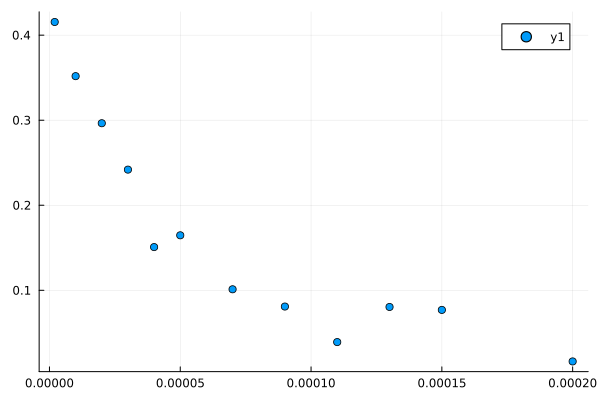

In [316]:
scatter(data_xs, data_ys)

In [317]:
ensemble_sol[1].u[end]

6-element Vector{Float64}:
 -4.2784210322230564e-6
  8.072166435151663e-6
 -6.18265685978341e-5
  0.007662366263220544
 -0.011560588030537654
  0.014383401034490416

In [318]:
T = @with_unit 125 "μK"
r, v, a = make_distributions(T, trap)
p = @params (trap, release_start_time, release_end_time, r, v, a)
;

In [319]:
# Create a release-recapture plot for a single temperature
release_durations = data_xs
surviving_fractions = zeros(length(release_durations))

for (i, release_duration) ∈ enumerate(release_durations)

    # Reset parameters for current run
    p.release_start_time = release_start_time
    p.release_end_time = release_start_time + release_duration

    prob = ODEProblem(update!, u0, tspan, p, save_on=false)
    ensemble_prob = EnsembleProblem(prob, prob_func=prob_func)
    @time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleSplitThreads(); trajectories=n)

    surviving_fractions[i] = mean(is_detectable(sol.u[end], p.trap) for sol ∈ ensemble_sol)
end

  0.493606 seconds (583.58 k allocations: 59.259 MiB, 119.19% compilation time: 35% of which was recompilation)
  0.290271 seconds (440.40 k allocations: 49.243 MiB)
  0.283404 seconds (440.28 k allocations: 49.233 MiB)
  0.229485 seconds (440.27 k allocations: 49.233 MiB)
  0.190812 seconds (440.28 k allocations: 49.233 MiB)
  0.148526 seconds (440.27 k allocations: 49.233 MiB)
  0.119207 seconds (440.27 k allocations: 49.233 MiB)
  0.087726 seconds (440.27 k allocations: 49.233 MiB)
  0.069357 seconds (440.15 k allocations: 49.223 MiB)
  0.058979 seconds (440.27 k allocations: 49.233 MiB)
  0.061648 seconds (440.28 k allocations: 49.233 MiB)
  0.045515 seconds (440.15 k allocations: 49.223 MiB)


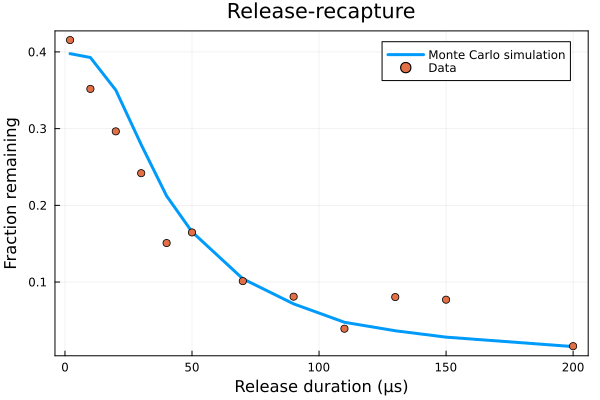

In [320]:
plot(release_durations .* 1e6, 0.4 * surviving_fractions,
    title="Release-recapture",
    linewidth=3,
    box=:on,
    label="Monte Carlo simulation",
    xlabel="Release duration (μs)",
    ylabel="Fraction remaining"
)
scatter!(data_xs  .* 1e6, data_ys, label="Data")

In [321]:
ηs = 15:45
Ts = T_depth ./ ηs

release_durations = data_xs
surviving_fractions = Vector{Float64}[]

iter = Ts
for (i, T) ∈ enumerate(Ts)
    display(ηs[i])
    r, v, a = make_distributions(T, trap)
    p = @params (trap, release_start_time, release_end_time, r, v, a)
    surviving_fraction = zeros(length(release_durations))

    for (j, release_duration) ∈ enumerate(release_durations)

        # Reset parameters for current run
        p.release_start_time = release_start_time
        p.release_end_time = release_start_time + release_duration
    
        prob = ODEProblem(update!, u0, tspan, p, save_on=false)
        ensemble_prob = EnsembleProblem(prob, prob_func=prob_func)
        @time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleSplitThreads(); trajectories=n)
    
        surviving_fraction[j] = mean(is_detectable(sol.u[end], p.trap) for sol ∈ ensemble_sol)
        
    end
    push!(surviving_fractions, surviving_fraction) 
end

15

  0.254568 seconds (440.15 k allocations: 49.222 MiB)
  0.255818 seconds (440.39 k allocations: 49.242 MiB)
  0.198354 seconds (440.28 k allocations: 49.233 MiB)
  0.161970 seconds (440.27 k allocations: 49.233 MiB)
  0.121694 seconds (440.27 k allocations: 49.232 MiB)
  0.096477 seconds (440.27 k allocations: 49.233 MiB)
  0.066495 seconds (440.28 k allocations: 49.233 MiB)
  0.064752 seconds (440.15 k allocations: 49.222 MiB)
  0.049365 seconds (440.27 k allocations: 49.233 MiB)
  0.046428 seconds (440.15 k allocations: 49.223 MiB)
  0.046998 seconds (440.28 k allocations: 49.233 MiB)
  0.038072 seconds (440.15 k allocations: 49.223 MiB)


16

  0.253156 seconds (440.15 k allocations: 49.222 MiB)
  0.246787 seconds (440.27 k allocations: 49.233 MiB)
  0.203108 seconds (440.27 k allocations: 49.233 MiB)
  0.167577 seconds (440.27 k allocations: 49.233 MiB)
  0.126480 seconds (440.28 k allocations: 49.233 MiB)
  0.100031 seconds (440.27 k allocations: 49.232 MiB)
  0.086553 seconds (440.28 k allocations: 49.233 MiB)
  0.059931 seconds (440.15 k allocations: 49.222 MiB)
  0.048363 seconds (440.28 k allocations: 49.233 MiB)
  0.044904 seconds (440.16 k allocations: 49.223 MiB)
  0.039103 seconds (440.28 k allocations: 49.233 MiB)
  0.042752 seconds (440.15 k allocations: 49.223 MiB)


17

  0.251643 seconds (440.15 k allocations: 49.223 MiB)
  0.257821 seconds (440.28 k allocations: 49.233 MiB)
  0.224466 seconds (440.27 k allocations: 49.233 MiB)
  0.177092 seconds (440.28 k allocations: 49.233 MiB)
  0.127835 seconds (440.27 k allocations: 49.233 MiB)
  0.120918 seconds (440.27 k allocations: 49.233 MiB)
  0.073660 seconds (440.27 k allocations: 49.233 MiB)
  0.055494 seconds (440.15 k allocations: 49.222 MiB)
  0.046562 seconds (440.28 k allocations: 49.233 MiB)
  0.048718 seconds (440.15 k allocations: 49.222 MiB)
  0.043573 seconds (440.27 k allocations: 49.233 MiB)
  0.422418 seconds (440.28 k allocations: 49.233 MiB, 90.68% gc time)


18

  0.268253 seconds (440.15 k allocations: 49.222 MiB)
  0.252540 seconds (440.27 k allocations: 49.233 MiB)
  0.218987 seconds (440.27 k allocations: 49.233 MiB)
  0.166485 seconds (440.27 k allocations: 49.233 MiB)
  0.146241 seconds (440.27 k allocations: 49.233 MiB)
  0.135802 seconds (440.27 k allocations: 49.233 MiB)
  0.100009 seconds (440.28 k allocations: 49.233 MiB)
  0.065920 seconds (440.28 k allocations: 49.233 MiB)
  0.051770 seconds (440.15 k allocations: 49.223 MiB)
  0.049500 seconds (440.28 k allocations: 49.233 MiB)
  0.055131 seconds (440.15 k allocations: 49.222 MiB)
  0.044358 seconds (440.27 k allocations: 49.233 MiB)


19

  0.284877 seconds (440.15 k allocations: 49.222 MiB)
  0.270822 seconds (440.28 k allocations: 49.233 MiB)
  0.231051 seconds (440.27 k allocations: 49.233 MiB)
  0.175822 seconds (440.28 k allocations: 49.233 MiB)
  0.139135 seconds (440.28 k allocations: 49.233 MiB)
  0.109942 seconds (440.27 k allocations: 49.233 MiB)
  0.082190 seconds (440.28 k allocations: 49.233 MiB)
  0.075153 seconds (440.27 k allocations: 49.233 MiB)
  0.062861 seconds (440.16 k allocations: 49.223 MiB)
  0.046772 seconds (440.28 k allocations: 49.233 MiB)
  0.053365 seconds (440.15 k allocations: 49.223 MiB)
  0.034893 seconds (440.28 k allocations: 49.233 MiB)


20

  0.268492 seconds (440.15 k allocations: 49.222 MiB)
  0.271274 seconds (440.28 k allocations: 49.233 MiB)
  0.236184 seconds (440.28 k allocations: 49.233 MiB)
  0.185295 seconds (440.27 k allocations: 49.233 MiB)
  0.139937 seconds (440.27 k allocations: 49.233 MiB)
  0.118519 seconds (440.28 k allocations: 49.233 MiB)
  0.084276 seconds (440.27 k allocations: 49.233 MiB)
  0.076164 seconds (440.28 k allocations: 49.233 MiB)
  0.057676 seconds (440.15 k allocations: 49.222 MiB)
  0.057279 seconds (440.27 k allocations: 49.233 MiB)
  0.042385 seconds (440.16 k allocations: 49.223 MiB)
  0.041170 seconds (440.27 k allocations: 49.233 MiB)


21

  0.247158 seconds (440.15 k allocations: 49.222 MiB)
  0.283162 seconds (440.28 k allocations: 49.233 MiB)
  0.230663 seconds (440.28 k allocations: 49.233 MiB)
  0.167680 seconds (440.27 k allocations: 49.233 MiB)
  0.157201 seconds (440.28 k allocations: 49.233 MiB)
  0.109248 seconds (440.28 k allocations: 49.233 MiB)
  0.090065 seconds (440.28 k allocations: 49.233 MiB)
  0.070303 seconds (440.15 k allocations: 49.222 MiB)
  0.058289 seconds (440.28 k allocations: 49.233 MiB)
  0.053881 seconds (440.15 k allocations: 49.223 MiB)
  0.053338 seconds (440.27 k allocations: 49.233 MiB)
  0.041875 seconds (440.15 k allocations: 49.222 MiB)


22

  0.266234 seconds (440.15 k allocations: 49.222 MiB)
  0.273066 seconds (440.27 k allocations: 49.233 MiB)
  0.249564 seconds (440.28 k allocations: 49.233 MiB)
  0.198288 seconds (440.28 k allocations: 49.233 MiB)
  0.153122 seconds (440.28 k allocations: 49.233 MiB)
  0.121128 seconds (440.27 k allocations: 49.233 MiB)
  0.090536 seconds (440.27 k allocations: 49.233 MiB)
  0.069606 seconds (440.27 k allocations: 49.233 MiB)
  0.057637 seconds (440.15 k allocations: 49.222 MiB)
  0.051508 seconds (440.27 k allocations: 49.233 MiB)
  0.749923 seconds (440.15 k allocations: 49.223 MiB, 93.59% gc time)
  0.045383 seconds (440.16 k allocations: 49.223 MiB)


23

  0.260396 seconds (440.15 k allocations: 49.222 MiB)
  0.285066 seconds (440.27 k allocations: 49.232 MiB)
  0.236948 seconds (440.27 k allocations: 49.233 MiB)
  0.198374 seconds (440.28 k allocations: 49.233 MiB)
  0.152687 seconds (440.28 k allocations: 49.233 MiB)
  0.121941 seconds (440.27 k allocations: 49.232 MiB)
  0.088371 seconds (440.28 k allocations: 49.233 MiB)
  0.069954 seconds (440.27 k allocations: 49.233 MiB)
  0.072049 seconds (440.16 k allocations: 49.223 MiB)
  0.064144 seconds (440.27 k allocations: 49.233 MiB)
  0.047228 seconds (440.15 k allocations: 49.223 MiB)
  0.043709 seconds (440.27 k allocations: 49.232 MiB)


24

  0.292453 seconds (440.15 k allocations: 49.222 MiB)
  0.280853 seconds (440.28 k allocations: 49.233 MiB)
  0.248995 seconds (440.28 k allocations: 49.233 MiB)
  0.192454 seconds (440.28 k allocations: 49.233 MiB)
  0.160151 seconds (440.27 k allocations: 49.233 MiB)
  0.137588 seconds (440.27 k allocations: 49.233 MiB)
  0.085424 seconds (440.28 k allocations: 49.233 MiB)
  0.076691 seconds (440.15 k allocations: 49.222 MiB)
  0.062928 seconds (440.28 k allocations: 49.233 MiB)
  0.051459 seconds (440.15 k allocations: 49.223 MiB)
  0.052606 seconds (440.28 k allocations: 49.233 MiB)
  0.043111 seconds (440.15 k allocations: 49.222 MiB)


25

  0.260353 seconds (440.15 k allocations: 49.222 MiB)
  0.294690 seconds (440.27 k allocations: 49.233 MiB)
  0.250224 seconds (440.27 k allocations: 49.233 MiB)
  0.211298 seconds (440.27 k allocations: 49.233 MiB)
  0.165614 seconds (440.27 k allocations: 49.232 MiB)
  0.125600 seconds (440.27 k allocations: 49.233 MiB)
  0.088139 seconds (440.27 k allocations: 49.233 MiB)
  0.075905 seconds (440.27 k allocations: 49.233 MiB)
  0.072744 seconds (440.16 k allocations: 49.223 MiB)
  0.051864 seconds (440.27 k allocations: 49.233 MiB)
  0.055609 seconds (440.15 k allocations: 49.223 MiB)
  0.043049 seconds (440.27 k allocations: 49.233 MiB)


26

  0.288448 seconds (440.15 k allocations: 49.222 MiB)
  0.255502 seconds (440.27 k allocations: 49.233 MiB)
  0.258468 seconds (440.27 k allocations: 49.233 MiB)
  0.222556 seconds (440.28 k allocations: 49.233 MiB)
  0.167425 seconds (440.28 k allocations: 49.233 MiB)
  0.147449 seconds (440.27 k allocations: 49.232 MiB)
  0.102539 seconds (440.27 k allocations: 49.233 MiB)
  0.075827 seconds (440.27 k allocations: 49.233 MiB)
  0.062306 seconds (440.15 k allocations: 49.222 MiB)
  0.059534 seconds (440.27 k allocations: 49.233 MiB)
  0.058653 seconds (440.16 k allocations: 49.223 MiB)
  0.040488 seconds (440.28 k allocations: 49.233 MiB)


27

  0.306396 seconds (440.15 k allocations: 49.222 MiB)
  0.297352 seconds (440.27 k allocations: 49.233 MiB)
  0.254871 seconds (440.27 k allocations: 49.233 MiB)
  0.211368 seconds (440.27 k allocations: 49.233 MiB)
  0.174627 seconds (440.28 k allocations: 49.233 MiB)
  0.137543 seconds (440.27 k allocations: 49.233 MiB)
  0.104798 seconds (440.27 k allocations: 49.232 MiB)
  0.078002 seconds (440.27 k allocations: 49.233 MiB)
  0.059413 seconds (440.16 k allocations: 49.223 MiB)
  0.060546 seconds (440.27 k allocations: 49.233 MiB)
  0.482969 seconds (440.27 k allocations: 49.233 MiB, 89.82% gc time)
  0.043346 seconds (440.16 k allocations: 49.223 MiB)


28

  0.285043 seconds (440.15 k allocations: 49.222 MiB)
  0.263141 seconds (440.27 k allocations: 49.232 MiB)
  0.270976 seconds (440.27 k allocations: 49.233 MiB)
  0.223780 seconds (440.28 k allocations: 49.233 MiB)
  0.174855 seconds (440.28 k allocations: 49.233 MiB)
  0.149549 seconds (440.28 k allocations: 49.233 MiB)
  0.112519 seconds (440.27 k allocations: 49.232 MiB)
  0.076774 seconds (440.27 k allocations: 49.233 MiB)
  0.056545 seconds (440.16 k allocations: 49.223 MiB)
  0.056977 seconds (440.28 k allocations: 49.233 MiB)
  0.052421 seconds (440.15 k allocations: 49.222 MiB)
  0.046237 seconds (440.27 k allocations: 49.233 MiB)


29

  0.273289 seconds (440.15 k allocations: 49.223 MiB)
  0.298176 seconds (440.27 k allocations: 49.233 MiB)
  0.249766 seconds (440.28 k allocations: 49.233 MiB)
  0.216149 seconds (440.27 k allocations: 49.233 MiB)
  0.176143 seconds (440.28 k allocations: 49.233 MiB)
  0.138614 seconds (440.28 k allocations: 49.233 MiB)
  0.111780 seconds (440.27 k allocations: 49.232 MiB)
  0.082851 seconds (440.28 k allocations: 49.233 MiB)
  0.069324 seconds (440.15 k allocations: 49.223 MiB)
  0.062665 seconds (440.28 k allocations: 49.233 MiB)
  0.051314 seconds (440.27 k allocations: 49.233 MiB)
  0.050961 seconds (440.16 k allocations: 49.223 MiB)


30

  0.280763 seconds (440.15 k allocations: 49.222 MiB)
  0.298910 seconds (440.27 k allocations: 49.233 MiB)
  0.286767 seconds (440.27 k allocations: 49.233 MiB)
  0.243300 seconds (440.27 k allocations: 49.232 MiB)
  0.178152 seconds (440.28 k allocations: 49.233 MiB)
  0.155142 seconds (440.27 k allocations: 49.233 MiB)
  0.109204 seconds (440.28 k allocations: 49.233 MiB)
  0.085640 seconds (440.27 k allocations: 49.233 MiB)
  0.072348 seconds (440.27 k allocations: 49.232 MiB)
  0.061681 seconds (440.15 k allocations: 49.223 MiB)
  0.052350 seconds (440.28 k allocations: 49.233 MiB)
  0.047784 seconds (440.16 k allocations: 49.223 MiB)


31

  0.291888 seconds (440.15 k allocations: 49.222 MiB)
  0.307173 seconds (440.27 k allocations: 49.233 MiB)
  0.269443 seconds (440.28 k allocations: 49.233 MiB)
  0.223017 seconds (440.28 k allocations: 49.233 MiB)
  0.183353 seconds (440.28 k allocations: 49.233 MiB)
  0.141870 seconds (440.28 k allocations: 49.233 MiB)
  0.094958 seconds (440.27 k allocations: 49.233 MiB)
  0.086522 seconds (440.27 k allocations: 49.233 MiB)
  0.072193 seconds (440.15 k allocations: 49.223 MiB)
  0.063684 seconds (440.28 k allocations: 49.233 MiB)
  0.053490 seconds (440.16 k allocations: 49.223 MiB)
  0.049816 seconds (440.27 k allocations: 49.233 MiB)


32

  0.300741 seconds (440.15 k allocations: 49.222 MiB)
  0.296521 seconds (440.28 k allocations: 49.233 MiB)
  0.272107 seconds (440.28 k allocations: 49.233 MiB)
  0.231782 seconds (440.28 k allocations: 49.233 MiB)
  0.216058 seconds (440.27 k allocations: 49.233 MiB)
  0.148001 seconds (440.27 k allocations: 49.233 MiB)
  0.123604 seconds (440.27 k allocations: 49.233 MiB)
  0.088911 seconds (440.28 k allocations: 49.233 MiB)
  0.076839 seconds (440.28 k allocations: 49.233 MiB)
  0.552183 seconds (440.27 k allocations: 49.233 MiB, 82.24% gc time)
  0.049480 seconds (440.16 k allocations: 49.223 MiB)
  0.049465 seconds (440.27 k allocations: 49.233 MiB)


33

  0.288573 seconds (440.15 k allocations: 49.222 MiB)
  0.311532 seconds (440.28 k allocations: 49.233 MiB)
  0.287469 seconds (440.28 k allocations: 49.233 MiB)
  0.250195 seconds (440.27 k allocations: 49.233 MiB)
  0.191389 seconds (440.27 k allocations: 49.232 MiB)
  0.162875 seconds (440.27 k allocations: 49.233 MiB)
  0.113118 seconds (440.28 k allocations: 49.233 MiB)
  0.088097 seconds (440.28 k allocations: 49.233 MiB)
  0.076076 seconds (440.28 k allocations: 49.233 MiB)
  0.063502 seconds (440.16 k allocations: 49.223 MiB)
  0.057250 seconds (440.28 k allocations: 49.233 MiB)
  0.053041 seconds (440.15 k allocations: 49.222 MiB)


34

  0.288962 seconds (440.15 k allocations: 49.222 MiB)
  0.271715 seconds (440.28 k allocations: 49.233 MiB)
  0.289299 seconds (440.28 k allocations: 49.233 MiB)
  0.265521 seconds (440.28 k allocations: 49.233 MiB)
  0.192983 seconds (440.27 k allocations: 49.233 MiB)
  0.173217 seconds (440.27 k allocations: 49.233 MiB)
  0.113959 seconds (440.28 k allocations: 49.233 MiB)
  0.091237 seconds (440.28 k allocations: 49.233 MiB)
  0.074262 seconds (440.15 k allocations: 49.223 MiB)
  0.071607 seconds (440.27 k allocations: 49.233 MiB)
  0.060012 seconds (440.15 k allocations: 49.223 MiB)
  0.054223 seconds (440.27 k allocations: 49.233 MiB)


35

  0.303961 seconds (440.15 k allocations: 49.222 MiB)
  0.300044 seconds (440.28 k allocations: 49.233 MiB)
  0.274333 seconds (440.27 k allocations: 49.232 MiB)
  0.265354 seconds (440.27 k allocations: 49.233 MiB)
  0.211314 seconds (440.28 k allocations: 49.233 MiB)
  0.170077 seconds (440.27 k allocations: 49.233 MiB)
  0.118646 seconds (440.28 k allocations: 49.233 MiB)
  0.089718 seconds (440.28 k allocations: 49.233 MiB)
  0.080515 seconds (440.27 k allocations: 49.233 MiB)
  0.061638 seconds (440.15 k allocations: 49.222 MiB)
  0.064976 seconds (440.28 k allocations: 49.233 MiB)
  0.048524 seconds (440.15 k allocations: 49.223 MiB)


36

  0.293391 seconds (440.15 k allocations: 49.222 MiB)
  0.298026 seconds (440.28 k allocations: 49.233 MiB)
  0.286170 seconds (440.28 k allocations: 49.233 MiB)
  0.228905 seconds (440.28 k allocations: 49.233 MiB)
  0.209422 seconds (440.27 k allocations: 49.233 MiB)
  0.177067 seconds (440.27 k allocations: 49.233 MiB)
  0.117915 seconds (440.27 k allocations: 49.232 MiB)
  0.086793 seconds (440.27 k allocations: 49.233 MiB)
  0.068209 seconds (440.15 k allocations: 49.222 MiB)
  0.061753 seconds (440.28 k allocations: 49.233 MiB)
  0.056919 seconds (440.28 k allocations: 49.233 MiB)
  0.053039 seconds (440.15 k allocations: 49.223 MiB)


37

  0.284546 seconds (440.15 k allocations: 49.223 MiB)
  0.295861 seconds (440.28 k allocations: 49.233 MiB)
  0.279473 seconds (440.28 k allocations: 49.233 MiB)
  0.248913 seconds (440.27 k allocations: 49.233 MiB)
  0.216892 seconds (440.28 k allocations: 49.233 MiB)
  0.161906 seconds (440.28 k allocations: 49.233 MiB)
  0.114342 seconds (440.27 k allocations: 49.233 MiB)
  0.097291 seconds (440.27 k allocations: 49.233 MiB)
  0.078355 seconds (440.28 k allocations: 49.233 MiB)
  0.439435 seconds (440.27 k allocations: 49.233 MiB, 83.19% gc time)
  0.067576 seconds (440.16 k allocations: 49.223 MiB)
  0.051419 seconds (440.15 k allocations: 49.223 MiB)


38

  0.303758 seconds (440.15 k allocations: 49.223 MiB)
  0.300861 seconds (440.27 k allocations: 49.233 MiB)
  0.294538 seconds (440.28 k allocations: 49.233 MiB)
  0.275384 seconds (440.27 k allocations: 49.233 MiB)
  0.217579 seconds (440.27 k allocations: 49.233 MiB)
  0.175076 seconds (440.28 k allocations: 49.233 MiB)
  0.121734 seconds (440.27 k allocations: 49.233 MiB)
  0.089442 seconds (440.28 k allocations: 49.233 MiB)
  0.081043 seconds (440.27 k allocations: 49.233 MiB)
  0.074943 seconds (440.16 k allocations: 49.223 MiB)
  0.058720 seconds (440.27 k allocations: 49.233 MiB)
  0.050015 seconds (440.15 k allocations: 49.222 MiB)


39

  0.284882 seconds (440.15 k allocations: 49.222 MiB)
  0.292223 seconds (440.27 k allocations: 49.233 MiB)
  0.293648 seconds (440.28 k allocations: 49.233 MiB)
  0.262167 seconds (440.28 k allocations: 49.233 MiB)
  0.202347 seconds (440.28 k allocations: 49.233 MiB)
  0.197956 seconds (440.28 k allocations: 49.233 MiB)
  0.132113 seconds (440.27 k allocations: 49.233 MiB)
  0.104628 seconds (440.27 k allocations: 49.233 MiB)
  0.085565 seconds (440.28 k allocations: 49.233 MiB)
  0.080270 seconds (440.28 k allocations: 49.233 MiB)
  0.058816 seconds (440.16 k allocations: 49.223 MiB)
  0.068496 seconds (440.27 k allocations: 49.233 MiB)


40

  0.301082 seconds (440.15 k allocations: 49.222 MiB)
  0.294120 seconds (440.27 k allocations: 49.232 MiB)
  0.279971 seconds (440.28 k allocations: 49.233 MiB)
  0.259988 seconds (440.27 k allocations: 49.233 MiB)
  0.215763 seconds (440.28 k allocations: 49.233 MiB)
  0.169921 seconds (440.27 k allocations: 49.232 MiB)
  0.123766 seconds (440.27 k allocations: 49.233 MiB)
  0.105707 seconds (440.28 k allocations: 49.233 MiB)
  0.092779 seconds (440.27 k allocations: 49.232 MiB)
  0.061328 seconds (440.15 k allocations: 49.222 MiB)
  0.056506 seconds (440.27 k allocations: 49.233 MiB)
  0.051217 seconds (440.16 k allocations: 49.223 MiB)


41

  0.291125 seconds (440.15 k allocations: 49.222 MiB)
  0.298933 seconds (440.27 k allocations: 49.233 MiB)
  0.286834 seconds (440.27 k allocations: 49.233 MiB)
  0.244138 seconds (440.27 k allocations: 49.233 MiB)
  0.204424 seconds (440.27 k allocations: 49.233 MiB)
  0.181310 seconds (440.28 k allocations: 49.233 MiB)
  0.126477 seconds (440.28 k allocations: 49.233 MiB)
  0.083179 seconds (440.27 k allocations: 49.233 MiB)
  0.081684 seconds (440.27 k allocations: 49.233 MiB)
  0.064029 seconds (440.16 k allocations: 49.223 MiB)
  0.057473 seconds (440.28 k allocations: 49.233 MiB)
  0.049157 seconds (440.15 k allocations: 49.223 MiB)


42

  0.287103 seconds (440.15 k allocations: 49.222 MiB)
  0.311742 seconds (440.28 k allocations: 49.233 MiB)
  0.284741 seconds (440.28 k allocations: 49.233 MiB)
  0.261521 seconds (440.27 k allocations: 49.233 MiB)
  0.200137 seconds (440.28 k allocations: 49.233 MiB)
  0.166430 seconds (440.28 k allocations: 49.233 MiB)
  0.154833 seconds (440.28 k allocations: 49.233 MiB)
  0.097966 seconds (440.28 k allocations: 49.233 MiB)
  0.519416 seconds (440.28 k allocations: 49.233 MiB, 84.96% gc time)
  0.072139 seconds (440.15 k allocations: 49.222 MiB)
  0.062165 seconds (440.28 k allocations: 49.233 MiB)
  0.051623 seconds (440.16 k allocations: 49.223 MiB)


43

  0.272588 seconds (440.15 k allocations: 49.222 MiB)
  0.306105 seconds (440.28 k allocations: 49.233 MiB)
  0.302779 seconds (440.28 k allocations: 49.233 MiB)
  0.258449 seconds (440.28 k allocations: 49.233 MiB)
  0.222504 seconds (440.28 k allocations: 49.233 MiB)
  0.179631 seconds (440.28 k allocations: 49.233 MiB)
  0.122485 seconds (440.28 k allocations: 49.233 MiB)
  0.101828 seconds (440.27 k allocations: 49.233 MiB)
  0.081327 seconds (440.28 k allocations: 49.233 MiB)
  0.071860 seconds (440.16 k allocations: 49.223 MiB)
  0.066998 seconds (440.27 k allocations: 49.233 MiB)
  0.069037 seconds (440.27 k allocations: 49.233 MiB)


44

  0.271824 seconds (440.15 k allocations: 49.222 MiB)
  0.295542 seconds (440.28 k allocations: 49.233 MiB)
  0.308003 seconds (440.28 k allocations: 49.233 MiB)
  0.277176 seconds (440.28 k allocations: 49.233 MiB)
  0.206087 seconds (440.27 k allocations: 49.233 MiB)
  0.184876 seconds (440.28 k allocations: 49.233 MiB)
  0.142051 seconds (440.27 k allocations: 49.233 MiB)
  0.101002 seconds (440.27 k allocations: 49.233 MiB)
  0.093618 seconds (440.28 k allocations: 49.233 MiB)
  0.073519 seconds (440.15 k allocations: 49.223 MiB)
  0.064645 seconds (440.28 k allocations: 49.233 MiB)
  0.048155 seconds (440.15 k allocations: 49.223 MiB)


45

  0.280089 seconds (440.16 k allocations: 49.222 MiB)
  0.261769 seconds (440.28 k allocations: 49.233 MiB)
  0.280996 seconds (440.27 k allocations: 49.233 MiB)
  0.275259 seconds (440.27 k allocations: 49.233 MiB)
  0.243041 seconds (440.28 k allocations: 49.233 MiB)
  0.180564 seconds (440.27 k allocations: 49.233 MiB)
  0.116416 seconds (440.28 k allocations: 49.233 MiB)
  0.093349 seconds (440.27 k allocations: 49.233 MiB)
  0.081675 seconds (440.27 k allocations: 49.233 MiB)
  0.079302 seconds (440.15 k allocations: 49.222 MiB)
  0.069172 seconds (440.27 k allocations: 49.233 MiB)
  0.050932 seconds (440.15 k allocations: 49.222 MiB)


In [322]:
χ²(data, preds) = sum((data .- preds).^2 ./ 0.04^2);

In [323]:
function model_with_best_scaling(data_ys, model_ys)
    min_error = Inf
    best_scaling = 1.0 
    for scaling ∈ 0.1:0.01:5.0
        error = χ²(data_ys, model_ys .* scaling)
        if error < min_error
            min_error = error
            best_scaling = scaling
        end
    end
    println(best_scaling)
    return model_ys .* best_scaling
end

model_with_best_scaling (generic function with 1 method)

In [324]:
χ²_errors = [
    χ²(
        data_ys,
        model_with_best_scaling(data_ys, surviving_fractions[i])
        )
    for i ∈ 1:size(surviving_fractions, 1)]
;

0.48
0.47
0.46
0.45
0.44
0.43
0.43
0.42
0.41
0.41
0.4
0.39
0.39
0.39
0.38
0.38
0.38
0.37
0.37
0.37
0.36
0.36
0.36
0.36
0.35
0.35
0.35
0.35
0.35
0.34
0.34


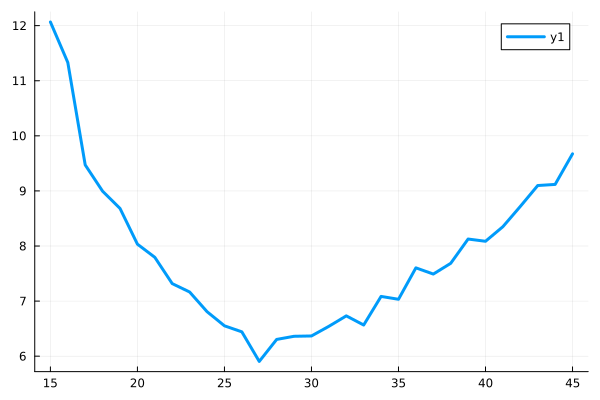

In [325]:
plot(T_depth ./ Ts, χ²_errors,
    linewidth=3,
    )

0.00015555555555555554

0.39


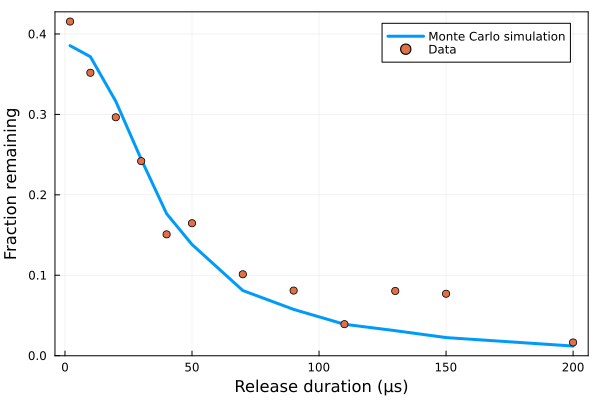

In [331]:
min_error, best_idx = findmin(χ²_errors)
Ts[best_idx] |> display
best_preds = model_with_best_scaling(data_ys, surviving_fractions[best_idx])

plot(release_durations .* 1e6, best_preds,
    title="",
    linewidth=3,
    box=:on,
    label="Monte Carlo simulation",
    xlabel="Release duration (μs)",
    ylabel="Fraction remaining"
)
scatter!(data_xs  .* 1e6, data_ys, label="Data")

In [332]:
using LsqFit
@. model(T, p) = p[1] * (T - p[2])^2 + p[3]

model (generic function with 1 method)

3-element Vector{Float64}:
  0.018967093953207705
 30.607559882800018
  6.330632721782503

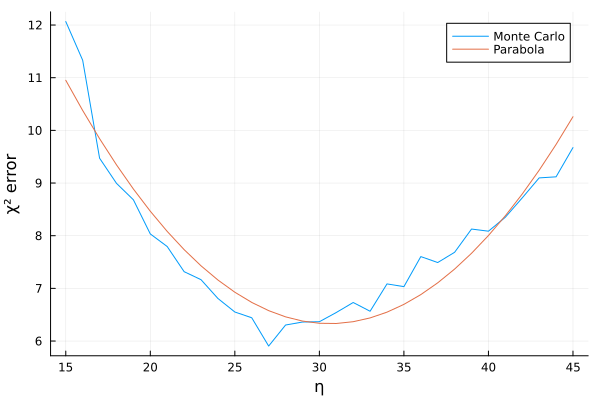

In [333]:
x = 0
y = 0

lb = [0, 0.0, 0.]
p0 = [0., 8, 0.]
ub = [1.0, 40, 35.0]
fitted_model = curve_fit(model, ηs[x+1:end-y], χ²_errors[x+1:end-y], p0, lower=lb, upper=ub)
display(fitted_model.param)
plot(ηs[x+1:end-y], χ²_errors[x+1:end-y], label="Monte Carlo", xlabel="η", ylabel="χ² error")
plot!(ηs[x+1:end-y], model(ηs[x+1:end-y], fitted_model.param), label="Parabola")

In [334]:
# The second derivative with respect to T is given by
best_η = fitted_model.param[2]
η_error = sqrt(2 * (2fitted_model.param[3])^(-1))
best_T = 1e6 * T_depth / fitted_model.param[2]
T_error = best_T * (η_error / best_η)
;

In [335]:
println("Best T fit: ", round(best_T, digits=2), "(", round(T_error, digits=0), ")")

Best T fit: 137.22(2.0)


### Bootstrap model outputs to get an error range

In [ ]:
surviving_fractions

In [24]:
n = 2_000
T = 60e-6
r, v, a = make_distributions(T)

simul_xs = collect(shaved_U_depth_ratios[1]:0.01:shaved_U_depth_ratios[end])

detectable_all = zeros(n, length(simul_xs))

for (j, shaved_U_depth_ratio) ∈ enumerate(simul_xs)
    shaved_U_depth = original_U_depth * shaved_U_depth_ratio

    # Reset parameters for current run
    p.time = 0.0
    p.shaved_U_depth = shaved_U_depth

    particles = StructArray{Particle}(undef, n)
    detectable = zeros(Bool, n)
    trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
    s = @params (detectable, trajectories)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
        dt_min, dt_max, abstol, true)

    detectable_all[:,j] .= s.detectable
    
end

LoadError: MethodError: no method matching make_distributions(::Float64)

[0mClosest candidates are:
[0m  make_distributions(::Any, [91m::AsymmetricGaussianTrap[39m)
[0m[90m   @[39m [36mBeamPropagation[39m [90mC:\Google Drive\github\BeamPropagation\src\[39m[90m[4mAsymmetricGaussianTrap.jl:54[24m[39m


In [25]:
n_bootstraps = 10000

surviving_fractions_lower = zeros(length(simul_xs))
surviving_fractions_upper = zeros(length(simul_xs))

for i ∈ eachindex(simul_xs)
    bootstrap_idxs = rand(1:n, n, n_bootstraps)
    bootstrap_samples = detectable_all[:,i][bootstrap_idxs]
    bootstrap_means = vec(mean(bootstrap_samples, dims=1))
    surviving_fractions_lower[i] = percentile(bootstrap_means, 50 - 34.1)
    surviving_fractions_upper[i] = percentile(bootstrap_means, 50 + 34.1)
end

LoadError: UndefVarError: `simul_xs` not defined

In [26]:
plot(simul_xs, surviving_fractions_lower, fillrange=surviving_fractions_upper, legend=nothing)

LoadError: UndefVarError: `surviving_fractions_upper` not defined

In [27]:
simul_vals = vec(mean(detectable_all, dims=1));

LoadError: UndefVarError: `detectable_all` not defined

In [28]:
simul_vals

LoadError: UndefVarError: `simul_vals` not defined

### Bootstrapping data

In [29]:
using Distributions

In [30]:
data_sampler(μs, ϵs) = [Normal(μs[i], ϵs[i]) for i ∈ eachindex(μs)]
ds = data_sampler(data_ys, data_ys_errors)
;

LoadError: UndefVarError: `data_ys_errors` not defined

In [31]:
n_bootstraps = 100_000
min_Ts = zeros(n_bootstraps)

for i ∈ 1:n_bootstraps
    bootstrap_sample = rand.(ds)
    squared_errors = vec(sum((bootstrap_sample .- surviving_fractions').^2 ./ length(data_ys), dims=1))
    _, best_idx = findmin(squared_errors)
    min_Ts[i] = Ts[best_idx]
end
histogram(min_Ts, bins=Ts)

LoadError: UndefVarError: `ds` not defined

In [32]:
mean(min_Ts)

0.0

In [33]:
percentile(min_Ts, 50 - 34.1) |> display
percentile(min_Ts, 50 + 34.1) |> display

0.0

0.0